In [0]:
!nvidia-smi

Sun Apr  5 09:56:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sqlite3
import os
import re
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(2)

import pandas as pd
import keras
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

TensorFlow 1.x selected.


Using TensorFlow backend.


# New Section

In [0]:
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/data/corona_tweets_1M.db')
c = conn.cursor()
df_pie = pd.read_sql("SELECT * FROM sentiment", conn)
total_tweets = df_pie.shape[0]
p_tweets = df_pie.apply(lambda x: True if x['sentiment'] > 0 else False , axis=1)
positive_tweets = len(p_tweets[p_tweets == True].index)
n_tweets = df_pie.apply(lambda x: True if x['sentiment'] < 0 else False , axis=1)
negative_tweets = len(n_tweets[n_tweets == True].index)
neutral_tweets = total_tweets - positive_tweets - negative_tweets

In [0]:
def assign_label(df):
    if df['sentiment'] > 0.3:
        return 'Positve'
    elif df['sentiment'] < -0.3:
        return 'Negative'
    else:
      return 'Neutral'
df_pie['label'] = df_pie.apply(assign_label, axis=1)

In [0]:
#training constants
MAX_SEQ_LEN = 25 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 128

In [0]:
train, test = train_test_split(df_pie, random_state = 42, test_size=0.1)
print(train.shape)
print(test.shape)

(1421061, 4)
(157896, 4)


In [0]:
def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    # Random note: removing the URL's slightly degraded performance, it's possible the model learned that certain URLs were positive/negative
    # And was able to extrapolate that to retweets. Could also explain why re-training the Embeddings improves performance.
    # remove twitter url's
#     text = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*","TWITTERURL",text)
    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(t)
    return ' '.join(mapped_string)

In [0]:
CONTRACTION_MAPPING = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [0]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)
train_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in train['tweet'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in test['tweet'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)


In [0]:
print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train["tweet"].values[10000])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[10000]]), '\n')

print('What the model will interpret:', train_text_vec[10000].tolist())

Number of Tokens: 403877
Max Token Index: 403877 

Sample Tweet Before Processing: RT @MarkYoungTruth: As usual @BernieSanders is lying. He said the Democrats are using it as a hoax never said the corona virus is a hoax.
Sample Tweet After Processing: ['RT MarkYoungTruth As usual BernieSanders is lying He said the Democrats are using it as a hoax never said the corona virus is a hoax'] 

What the model will interpret: [2, 1780, 493, 2498, 2014, 4, 1195, 262, 115, 1, 307, 8, 639, 12, 69, 7, 182, 158, 115, 1, 11, 9, 4, 7, 182]


In [0]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['label'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['label'].values)
y_test = to_categorical(y_test)

In [0]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(train['label'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)
cws = class_weight.compute_class_weight('balanced', np.unique(y_train_int), y_train_int)
print(cws)

Distribution of Classes: Counter({'Neutral': 1130113, 'Positve': 154675, 'Negative': 136273})
[3.47601506 0.41915012 3.06246646]


In [0]:
print('Dominant Class: ', ctr.most_common(n = 1)[0][0])
print('Baseline Accuracy Dominant Class', (ctr.most_common(n = 1)[0][0] == test['label'].values).mean())

preds = np.zeros_like(y_test)
preds[:, 0] = 1
preds[0] = 1 #done to suppress warning from numpy for f1 score
print('F1 Score:', f1_score(y_test, preds, average='weighted'))

Dominant Class:  Neutral
Baseline Accuracy Dominant Class 0.7954033034402391
F1 Score: 0.016838638849731427


In [0]:
# Naive Bayse Baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB()),
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using Naive Bayes: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

Baseline Accuracy Using Naive Bayes:  0.9050957592339262
F1 Score: 0.8940796028146756


[[5.69120169e-01 4.30220288e-01 6.59543596e-04]
 [7.08649505e-04 9.97420197e-01 1.87115319e-03]
 [1.16665694e-04 4.74012717e-01 5.25870618e-01]]
[[9.89564220e-01 4.66208296e-02 1.07991361e-03]
 [1.02064220e-02 8.95301467e-01 2.53779698e-02]
 [2.29357798e-04 5.80777038e-02 9.73542117e-01]]
[[5.46498961e-02 4.13120028e-02 6.33328267e-05]
 [5.63662157e-04 7.93351320e-01 1.48832143e-03]
 [1.26665653e-05 5.14642550e-02 5.70945432e-02]]


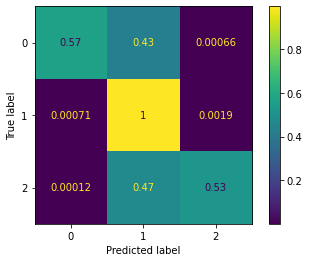

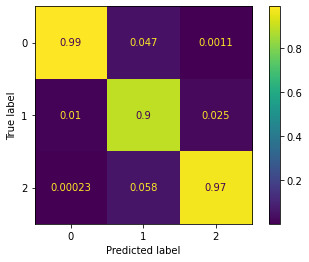

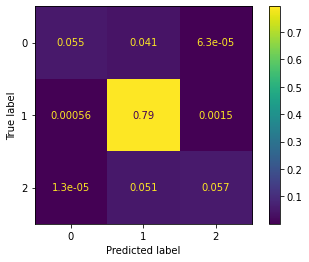

In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,plot_confusion_matrix

#print('Confusion Matrix :', confusion_matrix(y_test.argmax(axis = 1),predictions))
#print('Accuracy Score :', accuracy_score(y_test.argmax(axis = 1),predictions))
#print(test_text_vec)
for a in ['true','pred','all']:
  print(plot_confusion_matrix(text_clf,tokenizer.sequences_to_texts_generator(test_text_vec),y_test.argmax(axis = 1),normalize=a).confusion_matrix)


In [0]:
# Random Forest Baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

text_rf_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=20)), 
])
text_rf_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_rf_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using RFC: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

NameError: ignored

In [0]:
_ = plot_confusion_matrix(text_rf_clf,y_test.argmax(axis = 1), predictions, display_labels=encoder.classes_)
disp.ax_.set_title('Confusion matrix, without normalization')
_ = plot_confusion_matrix(text_rf_clf,y_test.argmax(axis = 1), predictions, display_labels=encoder.classes_, normalize=True)
disp.ax_.set_title('Confusion matrix, with normalization')

In [0]:
 def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train(model, 
          X_train, y_train, X_test, y_test, 
          checkpoint_path='model.hdf5', 
          epcohs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
          class_weights = None, 
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        #this is bad practice using test data for validation, in a real case would use a seperate validation set
        validation_data=(X_test, y_test),  
        epochs=epcohs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 
    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()    
    return m #returns best performing model

In [0]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def get_embdedings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = np.stack(embeddings_index.values())
    print('Shape of Full Embeddding Matrix', all_embs.shape)
    embed_dims = all_embs.shape[1]
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words: 
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower())
        # for twitter check if the key is a hashtag
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower())
            
        if embedding_vector is not None: 
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [0]:
def load_glove(word_index):
#     print('Loading Glove')
    embed_file_path = '/content/drive/My Drive/Colab Notebooks/models/glove.840B.300d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

In [0]:
def model_3(embed_matrix):
    """
    Extends model 1c, will be trained with multiple embeddings
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], output_dim = embed_matrix.shape[1], input_length = MAX_SEQ_LEN,  weights=[embed_matrix], trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
print('Loading Glove Model...')
glove_embed_matrix, words_not_found =  load_glove(tokenizer.word_index)
print("Model 3 w/ Glove Embedding")
_ = train(lambda : model_3(glove_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=0,
           print_summary = False

          )

Loading Glove Model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Built Embedding Index: 2196017


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


Shape of Full Embeddding Matrix (2196017, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



% of Vectors found in Corpus 0.3088762172641671
Model 3 w/ Glove Embedding










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: val_acc improved from -inf to 0.96320, saving model to model.hdf5

Epoch 00002: val_acc improved from 0.96320 to 0.97037, saving model to model.hdf5

Epoch 00003: val_acc improved from 0.97037 to 0.97044, saving model to model.hdf5


In [0]:
print('Loading Glove Model...')
glove_embed_matrix, words_not_found =  load_glove(tokenizer.word_index)
print("Model 3 w/ Glove Embedding")
_ = train(lambda : model_3(glove_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws,
           fit_verbose=0,
           print_summary = False

          )

Loading Glove Model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Built Embedding Index: 2196017


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


Shape of Full Embeddding Matrix (2196017, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



% of Vectors found in Corpus 0.3088762172641671
Model 3 w/ Glove Embedding










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: val_acc improved from -inf to 0.96303, saving model to model.hdf5

Epoch 00002: val_acc improved from 0.96303 to 0.97041, saving model to model.hdf5

Epoch 00003: val_acc improved from 0.97041 to 0.97066, saving model to model.hdf5

Epoch 00004: val_acc improved from 0.97066 to 0.97367, saving model to model.hdf5

Epoch 00005: val_acc improved from 0.97367 to 0.97446, saving model to model.hdf5

Epoch 00006: val_acc improved from 0.97446 to 0.97515, saving model to model.hdf5

Epoch 00007: val_acc improved from 0.97515 to 0.97582, saving model to model.hdf5

Epoch 00008: val_acc improved from 0.97582 to 0.97612, saving model to model.hdf5

Epoch 00009: val_acc improved from 0.97

NameError: ignored